<h3>Галлямов Артур, КЭ-403, лабораторная работа №1</h3>

Постановка задания:
1. Разработайте программу, которая выполняет поиск частых наборов объектов в заданном наборе данных с помощью алгоритма Apriori (или одной из его модификаций). Список результирующих наборов должен содержать как наборы, так и значение поддержки для каждого набора. Параметрами программы являются набор, порог поддержки и способ упорядочивания результирующего списка наборов (по убыванию значения поддержки или лексикографическое).
2. Проведите эксперименты на наборе данных baskets.csv (сведения о покупках в супермаркете). В экспериментах варьируйте пороговое значение поддержки (например: 1%, 3%, 5%, 10%, 15%).
3. Выполните визуализацию результатов экспериментов в виде следующих диаграмм:
сравнение быстродействия на фиксированном наборе данных при изменяемом пороге поддержки;
количество частых наборов объектов различной длины на фиксированном наборе данных при изменяемом пороге поддержки.
4. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
формулировка задания; 
гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами; 
рисунки с результатами визуализации; 
пояснения, раскрывающие смысл полученных результатов.

[Гиперссылка на репозиторий](https://github.com/gamingKenku/analytical-info-processing-tech/tree/main/lab1)

Реализация алгоритма Aprirori была взята из библиотеки MLxtend, используемой для решения задач машинного обучения и анализа данных. 
Для визуализации результатов расчета была использована библиотека Matplotlib.

In [66]:
# Импорт необходимых библиотек
import time
import enum
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt

<h3> Программа поиска частых наборов </h3>

In [67]:
# Чтение набора из файла и преобразование в список python
df = pd.read_csv('baskets.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,креветки,миндаль,авокадо,овощная смесь,зеленый виноград,цельнозерновая мука,батат,творог,энергетический напиток,томатный сок,низкокалорийный йогурт,зеленый чай,мед,салат,минеральная вода,лосось,ягодный сок,замороженный смузи,шпинат,оливковое масло
1,гамбургер,фрикадельки,яйца,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,чатни,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,индейка,авокадо,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,минеральная вода,молоко,энергетический батончик,рис,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,сливочное масло,низкокалорийный майонез,свежий хлеб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,гамбургер,замороженные овощи,яйца,картофель-фри,журнал,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,курица,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7499,эскалоп,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Перечисление методов сортировки
class SortMethod(enum.Enum):
    by_support = 'support'
    by_itemsets = 'itemsets'

def freq_itemsets(df: pd.DataFrame, min_support: float, sort_method: SortMethod=SortMethod.by_support):
    def sort_by_support(df: pd.DataFrame):
        return df.sort_values('support', ascending=False)

    def sort_by_itemsets(df: pd.DataFrame):
        return df.sort_values('itemsets')
    
    SORT_METHODS = {
        SortMethod.by_itemsets: sort_by_itemsets,
        SortMethod.by_support: sort_by_support
    }
    
    # Преобразование датасета для использования в алгоритме
    df = df.values.tolist()
    df = [[x for x in l if str(x) != 'nan'] for l in df]
    te = TransactionEncoder()
    te_ary = te.fit(df).transform(df)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # Выполнение алгоритма
    apr_df = apriori(df, min_support, use_colnames=True)

    # Сортировка заданным методом
    apr_df = SORT_METHODS[sort_method](apr_df)

    return apr_df

Пример поиска частых наборов при пороге поддержки 5%, сортированный по значениям поддержки:

In [69]:
supp_sorted_df = freq_itemsets(df, 0.05, SortMethod.by_support).head(10)
supp_sorted_df

,support,itemsets
11,0.238368,(минеральная вода)
10,0.187975,(макароны)
24,0.179709,(яйца)
7,0.170911,(картофель-фри)
22,0.163845,(шоколад)
5,0.132116,(зеленый чай)
12,0.129583,(молоко)
2,0.098254,(говяжий фарш)
3,0.095321,(замороженные овощи)
0,0.095054,(блинчики)


Выходной датасет показывает результаты выполнения алгоритма: значения поддержки и соответствующие им наборы.

<h3>Эксперименты</h3>

Сравнение быстродействия на фиксированном наборе данных при изменяемом пороге поддержки

<function matplotlib.pyplot.show(close=None, block=None)>

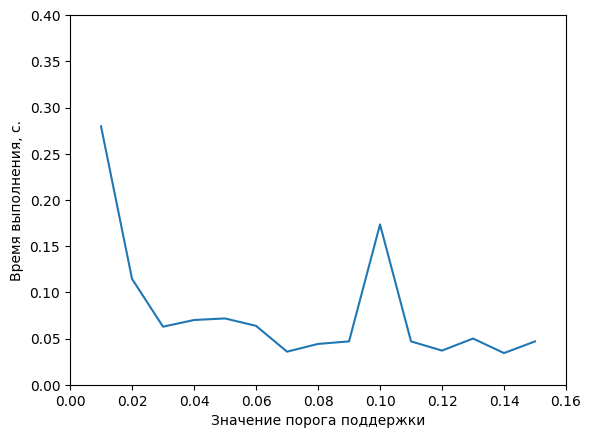

In [81]:
# Начальное значение порога поддержки и списки, используемые для построения графика
support = 0.01
support_list = []
execution_time_list = []

while support <= 0.15:
    start_time = time.time()
    apr_df = freq_itemsets(df, support, SortMethod.by_support)
    execution_time_list.append(time.time() - start_time)
    support_list.append(support)
    support += 0.01

plt.plot(support_list, execution_time_list)
plt.axis((0.0, 0.16, 0.0, 0.4))
plt.xlabel('Значение порога поддержки')
plt.ylabel('Время выполнения, с.')
plt.show


По построенному графику видно, что время выполнения алгоритма зависит от значения порога поддержки и обратно пропорционально ему: чем ниже порог, тем дольше выполнение. Также видны скачки времени выполнения в случайные моменты, но в целом тенденция остается такой же.

<function matplotlib.pyplot.show(close=None, block=None)>

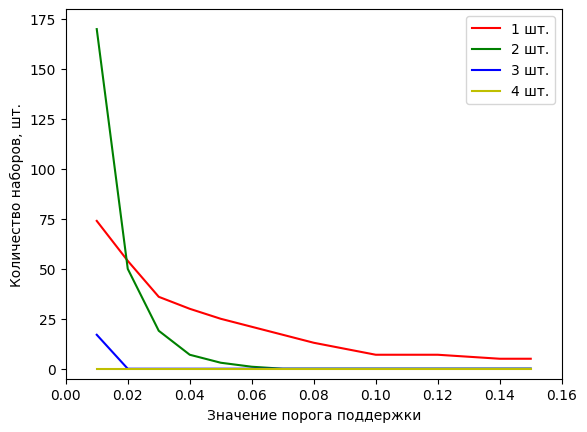

In [71]:
# Начальное значение порога поддержки и списки, используемые для построения графика
amount_1 = []
amount_2 = []
amount_3 = []
amount_4 = []
support = 0.01
support_list = []

while support <= 0.15:
    apr_df = freq_itemsets(df, support, SortMethod.by_support)
    apr_df['length'] = apr_df['itemsets'].apply(lambda x: len(x))

    amount_1.append(apr_df['length'].value_counts().get(1, 0))
    amount_2.append(apr_df['length'].value_counts().get(2, 0))
    amount_3.append(apr_df['length'].value_counts().get(3, 0))
    amount_4.append(apr_df['length'].value_counts().get(4, 0))
    
    support_list.append(support)
    support += 0.01

plt.plot(support_list, amount_1, 'r-', support_list, amount_2, 'g-', support_list, amount_3, 'b-', support_list, amount_4, 'y-')
plt.axis((0.0, 0.16, -5, 180))
plt.ylabel('Количество наборов, шт.')
plt.xlabel('Значение порога поддержки')
plt.legend(('1 шт.', '2 шт.', '3 шт.', '4 шт.'))
plt.show

Из построенного графика видно, что общее количество выявленных наборов уменьшается с увеличением порога поддержки. Также видно, что при низком пороге поддержки наиболее популярны наборы из двух элементов, а при его увеличении - из одного.